# Disaggregation

In [2]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [3]:
rcParams['figure.figsize'] = (13, 6)

### Dividing data into train and test set

In [4]:
train = DataSet('/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/smart_meter_train.h5')
test = DataSet('/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/smart_meter_test.h5')

Let us use building 1 for demo purposes

In [5]:
building = 1

Let's split data

In [6]:
#train.set_window(end="2013-10-19")
#test.set_window(start="2013-10-19")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='SMART_METER', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='SMART_METER', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=3, building=1, dataset='SMART_METER', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='SMART_METER', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='SMART_METER', appliances=[Appliance(type='kettle', instance=1)])
)

### Visualizing the data

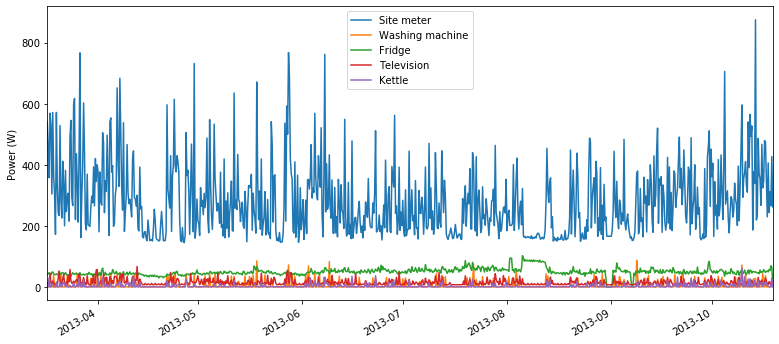

In [7]:
train_elec.plot()

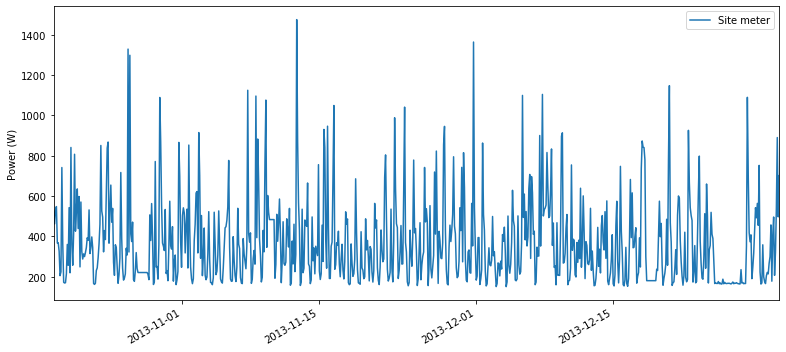

In [8]:
test_elec.mains().plot()

In [51]:
# consumption
meter = train_elec.mains()
meter_df = next(meter.load())
meter_df.describe()

physical_quantity,power
type,active
count,304791.000000
mean,279.870880
std,319.217255
min,106.000000
25%,154.500000
50%,176.833298
75%,271.236084
max,7184.700195


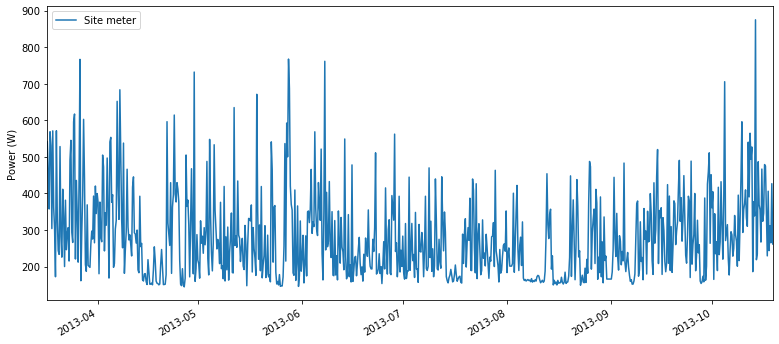

In [52]:
meter.plot()

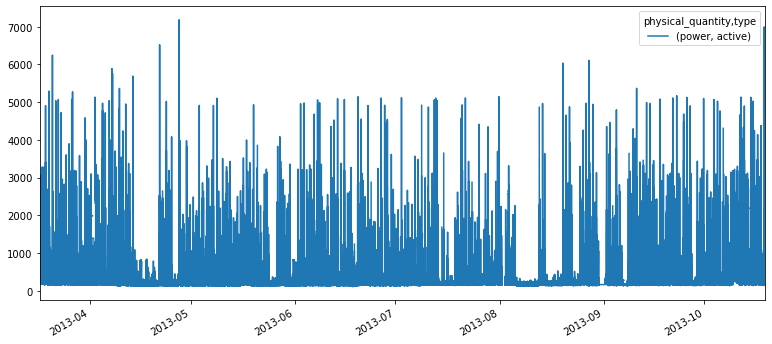

In [47]:
meter_df.plot()

In [40]:
meter = train_elec['washing machine']
#meter = train_elec['fridge']
#meter = train_elec['television']
#meter = train_elec['kettle']

In [41]:
meter_df = next(meter.load())

In [35]:
meter_df.describe()

physical_quantity,power
type,active
count,304791.000000
mean,3.125725
std,84.156944
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3084.000000


In [12]:
meter_df.head()

physical_quantity,power
type,active
2013-03-17 01:01:00+01:00,0.0
2013-03-17 01:02:00+01:00,0.0
2013-03-17 01:03:00+01:00,0.0
2013-03-17 01:04:00+01:00,0.0
2013-03-17 01:05:00+01:00,0.0


In [13]:
meter_df.tail()

physical_quantity,power
type,active
2013-10-19 01:55:00+02:00,104.444397
2013-10-19 01:56:00+02:00,62.777802
2013-10-19 01:57:00+02:00,103.777802
2013-10-19 01:58:00+02:00,85.875000
2013-10-19 01:59:00+02:00,137.444397


In [18]:
mains_test = test_elec.mains()
mains_test_df = next(mains_test.load())
mains_test_df.describe()

physical_quantity,power
type,active
count,102577.000000
mean,374.192291
std,399.326416
min,142.000000
25%,178.000000
50%,260.000000
75%,411.777802
max,7571.222168


In [19]:
mains_test_df.head()

physical_quantity,power
type,active
2013-10-19 02:00:00+02:00,563.333313
2013-10-19 02:01:00+02:00,392.000000
2013-10-19 02:02:00+02:00,493.125000
2013-10-19 02:03:00+02:00,482.000000
2013-10-19 02:04:00+02:00,469.285706


In [20]:
mains_test_df.tail()

physical_quantity,power
type,active
2014-01-01 00:55:00+01:00,342.666687
2014-01-01 00:56:00+01:00,311.555603
2014-01-01 00:57:00+01:00,310.500000
2014-01-01 00:58:00+01:00,312.000000
2014-01-01 00:59:00+01:00,310.444397


### Training and disaggregation

#### A function to disaggregate the mains data to constituent appliances and return the predictions

In [ ]:
def predict(clf, test_elec, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active')):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active'))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

#### Train using 2 benchmarking algorithms -  Combinatorial Optimisation (CO) and Factorial Hidden Markov Model (FHMM)

In [ ]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    clf.train(train_elec)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, train.metadata['timezone'])
   

Using prettier labels!

In [ ]:
appliance_labels = [m.label() for m in gt.columns.values]

In [ ]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

#### Taking a look at the ground truth of top 5 appliance power consumption

In [ ]:
gt.head()

In [ ]:
predictions['CO'].head()

In [ ]:
predictions['FHMM'].head()

### Plotting the predictions against the actual usage

In [ ]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

In [ ]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

### Comparing NILM algorithms (CO vs FHMM)

`nilmtk.utils.compute_rmse` is an extended of the following, handling both missing values and labels better:
```python
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
```

In [ ]:
? nilmtk.utils.compute_rmse

In [ ]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

In [ ]:
predictions['FHMM']

In [ ]:
#predictions['CO'].drop("epoch_time", axis = 1, inplace = True)
predictions['CO'].insert(0, 'epoch_time', predictions['CO'].index.strftime('%s'))
# Save CO predictions to file
predictions['CO'].to_csv (r'/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/smart_meter_predictions_CO.csv', index = False, header=True)

In [ ]:
#predictions['FHMM'].drop("epoch_time", axis = 1, inplace = True)
predictions['FHMM'].insert(0, 'epoch_time', predictions['FHMM'].index.strftime('%s'))
# Save FHMM predictions to file
predictions['FHMM'].to_csv (r'/Users/i050650/Documents/DEV/git/smart-meter/nilmtk-tests/generated/smart_meter_predictions_FHMM.csv', index = False, header=True)